In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [2]:
from math import floor

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from src.part3.MLP import MultiLayerPerceptron as MLP
from src.part6.MatrixMultiplication import MatrixMultiplication
from src.part6.mpc import MPC

## Pytorch 환경모델을 활용한 Model predictive control

$$
\begin{aligned}
 \min_{\{u_t\}_{t=1}^{H}} &\, \sum_{t=1}^{t=H} (x_t-\bar x_t)^{\top}Q(x_t-\bar x_t) + u_t^{\top} R u_t + \Delta u_t^{\top} \bar R \Delta u_t  \\
 \text{s.t.} &\, x_{t+1} = f_{\theta}(x_t, u_t) \, \forall t={1...H}\\
             &\, u_{min} \leq u_t \leq u_{max} \, \forall t={1...H}\\
\end{aligned}
$$

위에 기술된 최적화 문제는 Receding horizon control problem 이라고도 불리는 최적제어 문제의 한 형태입니다. MPC 수업에서는 다루었던 문제에서 Cost 항을 Quadratic하게 바꿔주고 상태천이에 대한 제약조건과 추가적으로 우리가 시스템에 가할 수 있는 행동 u의 범위를 Box constraint로 표현하였습니다.

목적함수 $x_t$ 는 시점 $t$ 의 시스템의 상태를 나타냅니다. $\bar x_t$ 는 시점 $t$ 원하는 시스템의 상태입니다 (reference state 라고도 불립니다) $u_t$는 시점 $t$의 행동을 표현하는 벡터입니다. $\Delta u_t$ 는 $u_{t}-u_{t-1}$로 정의됩니다. $Q$ 는 시스템의 상태가 우리가 원하는 지점에서 멀어지는것에 대한 페널티 매트릭스입니다. $R$는 행동의 크기에 대한 패널티 매트릭스입니다. 일반적으로 원하는 trajectory를 만들어 낼수 있다면 최대한 작은 행동을 하는 것을 선호하기 때문에 $R$의 원소는 양수값이 됩니다. $\bar R$는 행동의 변화량에 대한 패널티 매트릭스입니다. 실제로 존재하는 시스템을 제어할 때 빠르게 변화하는 $u_t$ 는 시스템에 부담이 될 수 있기 때문에 행동의 변화량에도 패널티를 주곤 합니다.

## MPC를 활용한 제어문제를 검증하기 위한 시뮬레이터와 모델

최적 제어문제가 정말 최적해를 내놓게 되는지를 검증하기 위해서 간단한 시뮬레이터와 모델을 구축해봅시다.
우리가 제어하려는 시스템의 true dyanmic이 다음과 같이 표현된다고 생각해봅시다. 
$$y=Ax+Bu+\epsilon$$

실제 시스템이 선형이므로 모델도 선형으로 만들어보도록 할까요? 

>개념 검증을 위해 선형 dynamic과 모델을 사용하였습니다. 이런 선택이 뒤에서 다루게될 코드가 선형에서만 작동하는 것을 의미하는 것은 아닙니다.

In [3]:
class Simulator(nn.Module):
    
    def __init__(self, state_dim, action_dim):
        super(Simulator, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.A = MatrixMultiplication(state_dim, state_dim)
        self.B = MatrixMultiplication(action_dim, state_dim)
        self.epsilon = 0.01
    
    def forward(self, x, u):
        return self.A(x) + self.B(u)+torch.ones(1,state_dim)*np.random.normal(0,self.epsilon)

    
class SimpleSSM(nn.Module):
    
    def __init__(self, state_dim, action_dim):
        super(SimpleSSM, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.A = MatrixMultiplication(state_dim, state_dim)
        self.B = MatrixMultiplication(action_dim, state_dim)
    
    def forward(self, x, u):
        return self.A(x) + self.B(u)

In [4]:
state_dim = 2
action_dim = 3

model = SimpleSSM(state_dim, action_dim)
simul = Simulator(state_dim, action_dim)

A=np.array([[0.9, 0.1],
            [0.1,0.9]])

B=np.array([[1, -1],
            [-1, 2],
            [-2, 1]])

model.A.weight.data = torch.Tensor(A).float()
simul.A.weight.data = torch.Tensor(A).float()
model.B.weight.data = torch.Tensor(B).float()
simul.B.weight.data = torch.Tensor(B).float()

## 최적화 문제의 목적함수 및 제약조건을 표현해봅시다.

In [5]:
H = 5 # length of reeding horizon
T = 100 # simulation steps

Q=torch.eye(state_dim) * 10
R=torch.eye(action_dim) * 0
r=torch.eye(action_dim)*0

x_ref = torch.ones((T, state_dim)) * 10
recession_period = floor(T * 0.2)
x_ref[:recession_period, :] = 0
x_ref[-recession_period:, :] = 0

action_min = -1.0
action_max = 1.0

## `scipy.optmize.minimize` 와 `torch` 모델을 활용해 MPC 구현하기

$$\min _{u_{1}, \ldots, u_{H}} \sum_{t=1}^{H} c\left(x_{t}, u_{t}\right) \text { s.t. } x_{t}=f\left(x_{t-1},u_{t-1}\right), u_{min} \leq u_t \leq u_{max} \forall t={1...H}$$

$$
\begin{aligned}
 \min_{\{u_t\}_{t=1}^{H}} &\, \sum_{t=1}^{t=H} c(x_t,u_t)  \\
 \text{s.t.} &\, x_{t+1} = f_{\theta}(x_t, u_t) \, \forall t={1...H}\\
             &\, u_{min} \leq u_t \leq u_{max} \, \forall t={1...H}\\
\end{aligned}
$$

(편의를 위해서 앞서 정의한 문제의 $t$ 시점의 cost 를 $c(x_t, u_t)$ 로 기술하였습니다.)

`MPC`를 구현하는 방법은 다양합니다. 행동에 대한 제약조건이 존재하지 않는다면 iLQR도 하나의 방법이 될수 있겠지요. 우리는 `SLSQP` (수업시간에 다룬 `SQP`)과 `torch` 모델로 표현된 $f_{\theta}(x_t, u_t)$ 로 MPC를 구현하는 방법을 알아보도록 합시다. `scipy.optimize.minimize`를 활용해 MPC를 구현하는 의사코드는 다음과 같습니다.

1. 환경모델과 코스트함수를 합성해서 표현해줍니다.
$$\min _{u_{1}, \ldots, u_{H}} c\left(x_{1}, u_{1}\right)+c\left(f\left(x_{1}, u_{1}\right), u_{2}\right)+\cdots+c\left(f(f(\ldots) \ldots), u_{H}\right)$$

2. 행동에 대한 제약식 설정 (예시에서는 box constraint)

3. `scipy SLSQP` 솔버로 최적화 문제 풀이.

## `MPC` 솔버 만들기

제 구현에서는, `MPC` 클래스의 객체가 매 시점마다 시스템에서 관측되는 상태에 대해서 MPC문제를 풀어서 최적 행동 trajectory를 구하는 형태로 MPC솔버가 구현되어 있습니다. `MPC` 클래스에서 instance를 하나 만들어 보도록 하죠.

In [6]:
# Refer to src.part6.mpc.py 

solver = MPC(model, 
             state_dim, 
             action_dim, 
             H, 
             x_ref, 
             action_min, 
             action_max, 
             Q, R, r)

## 시뮬레이션을 활용해서 MPC 검증

앞서 정의한 시뮬레이터와 `MPC`클래스를 이용해서 실제로 MPC를 통한 제어가 잘 작동하는지 알아보도록 합시다.

In [7]:
x = torch.zeros(1,state_dim)
state_trajectory = []
action_trajectory = []
opt_results = []

for itr in range(T-H):
    # Solve MPC problem
    state_ref = x_ref[itr:itr+H,:]
    solver.set_mpc_params(x,state_ref)
    opt_actions, pred_states, opt_result = solver.solve()    
    action = opt_actions[0]
    
    # perform simulation with the optmized action
    with torch.no_grad():
        x = simul(x,action.view(1,-1))
    
    action_trajectory.append(action.numpy())
    state_trajectory.append(x.numpy())
    opt_results.append(opt_result)

In [8]:
state_trajectory = np.stack(state_trajectory).squeeze()
action_trajectory = np.stack(action_trajectory).squeeze()

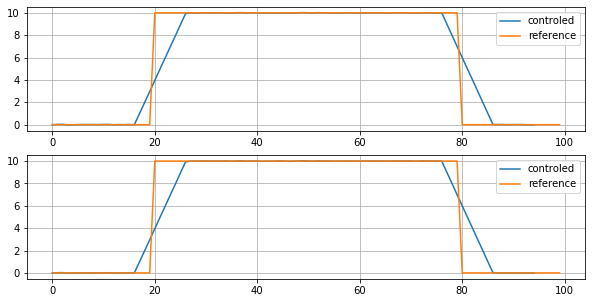

In [9]:
fig, axes = plt.subplots(state_dim,1, figsize=(10,5))
for i in range(state_dim):
    axes[i].grid()
    axes[i].plot(state_trajectory[:, i], label='controled')
    axes[i].plot(x_ref[:, i], label='reference')
    axes[i].legend()

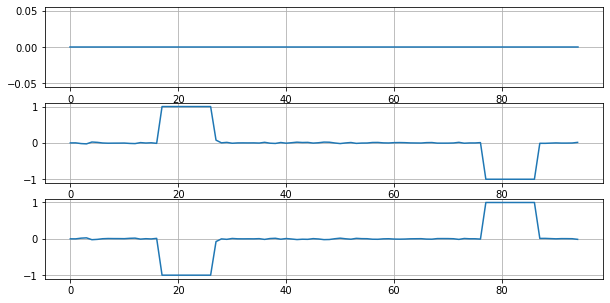

In [10]:
fig, axes = plt.subplots(action_dim,1, figsize=(10,5))
for i in range(action_dim):
    axes[i].grid()
    axes[i].plot(action_trajectory[:, i], label='actions')

## 만약에 모델이 틀리면 어쩌죠?

MPC의 제어성능은 (1) 얼마나 모델이 미래를 잘 예측하는가? (2) 최적화 문제를 잘 푸는가? 두 가지에 의해 결정됩니다. (물론 시스템이 '제어가능'하다는 가정이 필요하겠죠)  문제(2)는 대부분의 경우 우리의 손 밖에 문제입니다. (1)의 경우는 얼마나 좋은 모델을 만드느냐 인데, 일반적으로 자기 자신의 예측값을 사용해서 trajectory를 예측하는 경우엔 좋은 모델을 얻는것이 쉽지 않습니다. 특히, function approximation 을 사용하는 learning 모델들의 경우 항상 어느정도 수준의 function approximation error가 존재하기 때문에 좋은 모델을 얻는 것이 더욱 쉽지 않죠. 

다행히도! MPC는 매 시점마다 replanning 을 하기 때문에 모델링 에러에 대해서 -openloop control 기법에 비해서- 강인한 모습을 보입니다. 한번 결과를 같이 살펴볼까요?

In [11]:
noise_level = 1e-2

model_corrupted = SimpleSSM(state_dim, action_dim)

A_corrupted = A + np.random.randn(state_dim, state_dim) * noise_level # add noise on paramters
B_corrupted = B + np.random.randn(action_dim, state_dim) * noise_level # add noise on paramters

model_corrupted.A.weight.data = torch.Tensor(A_corrupted).float()
model_corrupted.B.weight.data = torch.Tensor(B_corrupted).float()

In [12]:
H = 2

In [13]:
solver = MPC(model_corrupted, 
             state_dim, 
             action_dim, 
             H, 
             state_ref, 
             action_min, 
             action_max, 
             Q, R, r)

In [14]:
x = torch.zeros(1,state_dim)
state_trajectory = []
action_trajectory = []

for itr in range(T-H):
    # Solve MPC problem
    state_ref = x_ref[itr:itr+H,:]
    solver.set_mpc_params(x,state_ref)
    opt_actions, pred_states, opt_result = solver.solve()    
    action = opt_actions[0]
    
    # perform simulation with the optmized action
    with torch.no_grad():
        x = simul(x,action.view(1,-1))
    
    action_trajectory.append(action.numpy())
    state_trajectory.append(x.numpy())

In [15]:
state_trajectory = np.stack(state_trajectory).squeeze()
action_trajectory = np.stack(action_trajectory).squeeze()

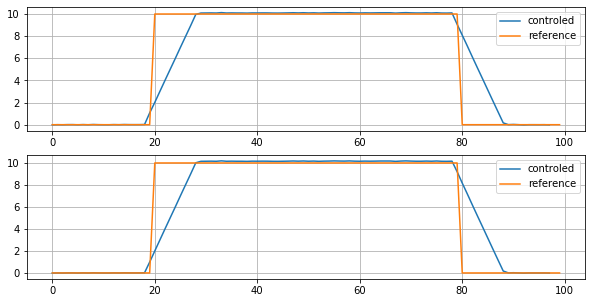

In [16]:
fig, axes = plt.subplots(state_dim,1, figsize=(10,5))
for i in range(state_dim):
    axes[i].grid()
    axes[i].plot(state_trajectory[:, i], label='controled')
    axes[i].plot(x_ref[:, i], label='reference')
    axes[i].legend()

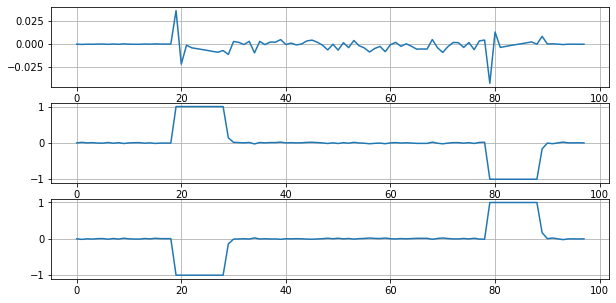

In [17]:
fig, axes = plt.subplots(action_dim,1, figsize=(10,5))
for i in range(action_dim):
    axes[i].grid()
    axes[i].plot(action_trajectory[:, i], label='actions')